# Seq2Seq Q&A Chatbot 구현 실습

### 데이터 취득

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv')
df = df[['Q','A']]
df

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


### 데이터 전처리

In [4]:
# 학습용 텍스트 파일 생성 (Q + A)
que = df['Q'].tolist()  # 질문 리스트
ans = df['A'].tolist()  # 답변 리스트

ans_input = ['<sos> ' + text for text in ans]
ans_target = [text + ' <eos>' for text in ans]

len(que), len(ans_input), len(ans_target)

(11823, 11823, 11823)

In [35]:
ans_target[:5]

['하루가 또 가네요. <eos>',
 '위로해 드립니다. <eos>',
 '여행은 언제나 좋죠. <eos>',
 '여행은 언제나 좋죠. <eos>',
 '눈살이 찌푸려지죠. <eos>']

##### 토커나이저 학습 (sentencepiece 활용)
- 접두사, 접미사 처리

In [5]:
VOCAB_SIZE = 9000

In [6]:
import sentencepiece as spm

# 학습 데이터 파일 생성
# with open('que_ans.txt', 'w', encoding='utf-8') as f:
#     for q, a in zip(que, ans_input + ans_target):
#         f.write(f'{q}\n')
#         f.write(f'{a}\n')

# SentencePiece 모델 학습
input = 'que_ans.txt'
vocab_size = VOCAB_SIZE
model_prefix = 'que_ans'
cmd = f'--input={input} --model_prefix={model_prefix} --vocab_size={vocab_size}'
spm.SentencePieceTrainer.Train(cmd)

In [7]:
# 모델 로드
sp = spm.SentencePieceProcessor()
sp.load('que_ans.model')

# 토큰화된 시퀀스 생성
que_sequences = [sp.encode_as_ids(text) for text in que]
ans_input_sequences = [sp.encode_as_ids(text) for text in ans_input]
ans_target_sequences = [sp.encode_as_ids(text) for text in ans_target]

que_max_len = max([len(seq) for seq in que_sequences])
ans_max_len = max([len(seq) for seq in ans_input_sequences])
que_max_len, ans_max_len

(24, 41)

In [9]:
que_max_words = min(VOCAB_SIZE,len(set([word for seq in que_sequences for word in seq])))
que_max_len = max(len(seq) for seq in que_sequences)

In [19]:
ans_num_words = min(VOCAB_SIZE,len(set([word for seq in ans_input_sequences for word in seq])))
ans_max_len = max(len(seq) for seq in ans_input_sequences)

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

que_padded = pad_sequences(que_sequences, maxlen=que_max_len, padding='pre')
ans_input_padded = pad_sequences(ans_input_sequences, maxlen=ans_max_len, padding='post')
ans_target_padded = pad_sequences(ans_target_sequences, maxlen=ans_max_len, padding='post')

que_padded.shape, ans_input_padded.shape, ans_target_padded.shape

((11823, 24), (11823, 41), (11823, 41))

##### 학습용 데이터 Q_input, A_input, A_target 생성

In [11]:
# 학습용 데이터 생성
Q_input = que_padded
A_input = ans_input_padded
A_target = ans_target_padded

Q_input.shape, A_input.shape, A_target.shape

((11823, 24), (11823, 41), (11823, 41))

### 모델 생성

##### 인코더 생성

In [23]:
from tensorflow.keras import layers, models

LATENT_DIM = 512
EMBEDDING_DIM = 100

# 인코더 모델 
encoder_inputs = layers.Input(shape=(que_max_len,))
en_embedding_layer = layers.Embedding(vocab_size+1, EMBEDDING_DIM)
x = en_embedding_layer(encoder_inputs)
encoder_outputs, h, c = layers.LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [h, c]

encoder_model = models.Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 24, 100)        │       900,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ [(None, 512), (None,   │     1,255,424 │
│                                 │ 512), (None, 512)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,524 (8.22 MB)

 Trainable params: 2,155,524 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

##### 디코더 (teacher-forcing 모델) 생성

In [24]:
decoder_inputs = layers.Input(shape=(ans_max_len,))
que_embedding_layer = layers.Embedding(vocab_size+1,EMBEDDING_DIM)
x = que_embedding_layer(decoder_inputs)
decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, h, c = decoder_lstm(x, initial_state=encoder_states)

decoder_dense = layers.Dense(vocab_size+1, activation='softmax')
decoder_outputs = decoder_dense(x)

decoder_teacher_forcing_model = models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_outputs
)
decoder_teacher_forcing_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 41)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 24, 100)   │    900,100 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 41, 100)   │    900,100 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 512),     │  1,255,424 │ embedding_4[0][0] │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 41, 512), │  1,255,424 │ embedding_5[0][0… │
│                     │ (None, 512),      │            │ lstm_4[0][1],     │
│                     │ (None, 512)]      │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 41, 9001)  │  4,617,513 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,928,561 (34.06 MB)

 Trainable params: 8,928,561 (34.06 MB)

 Non-trainable params: 0 (0.00 B)

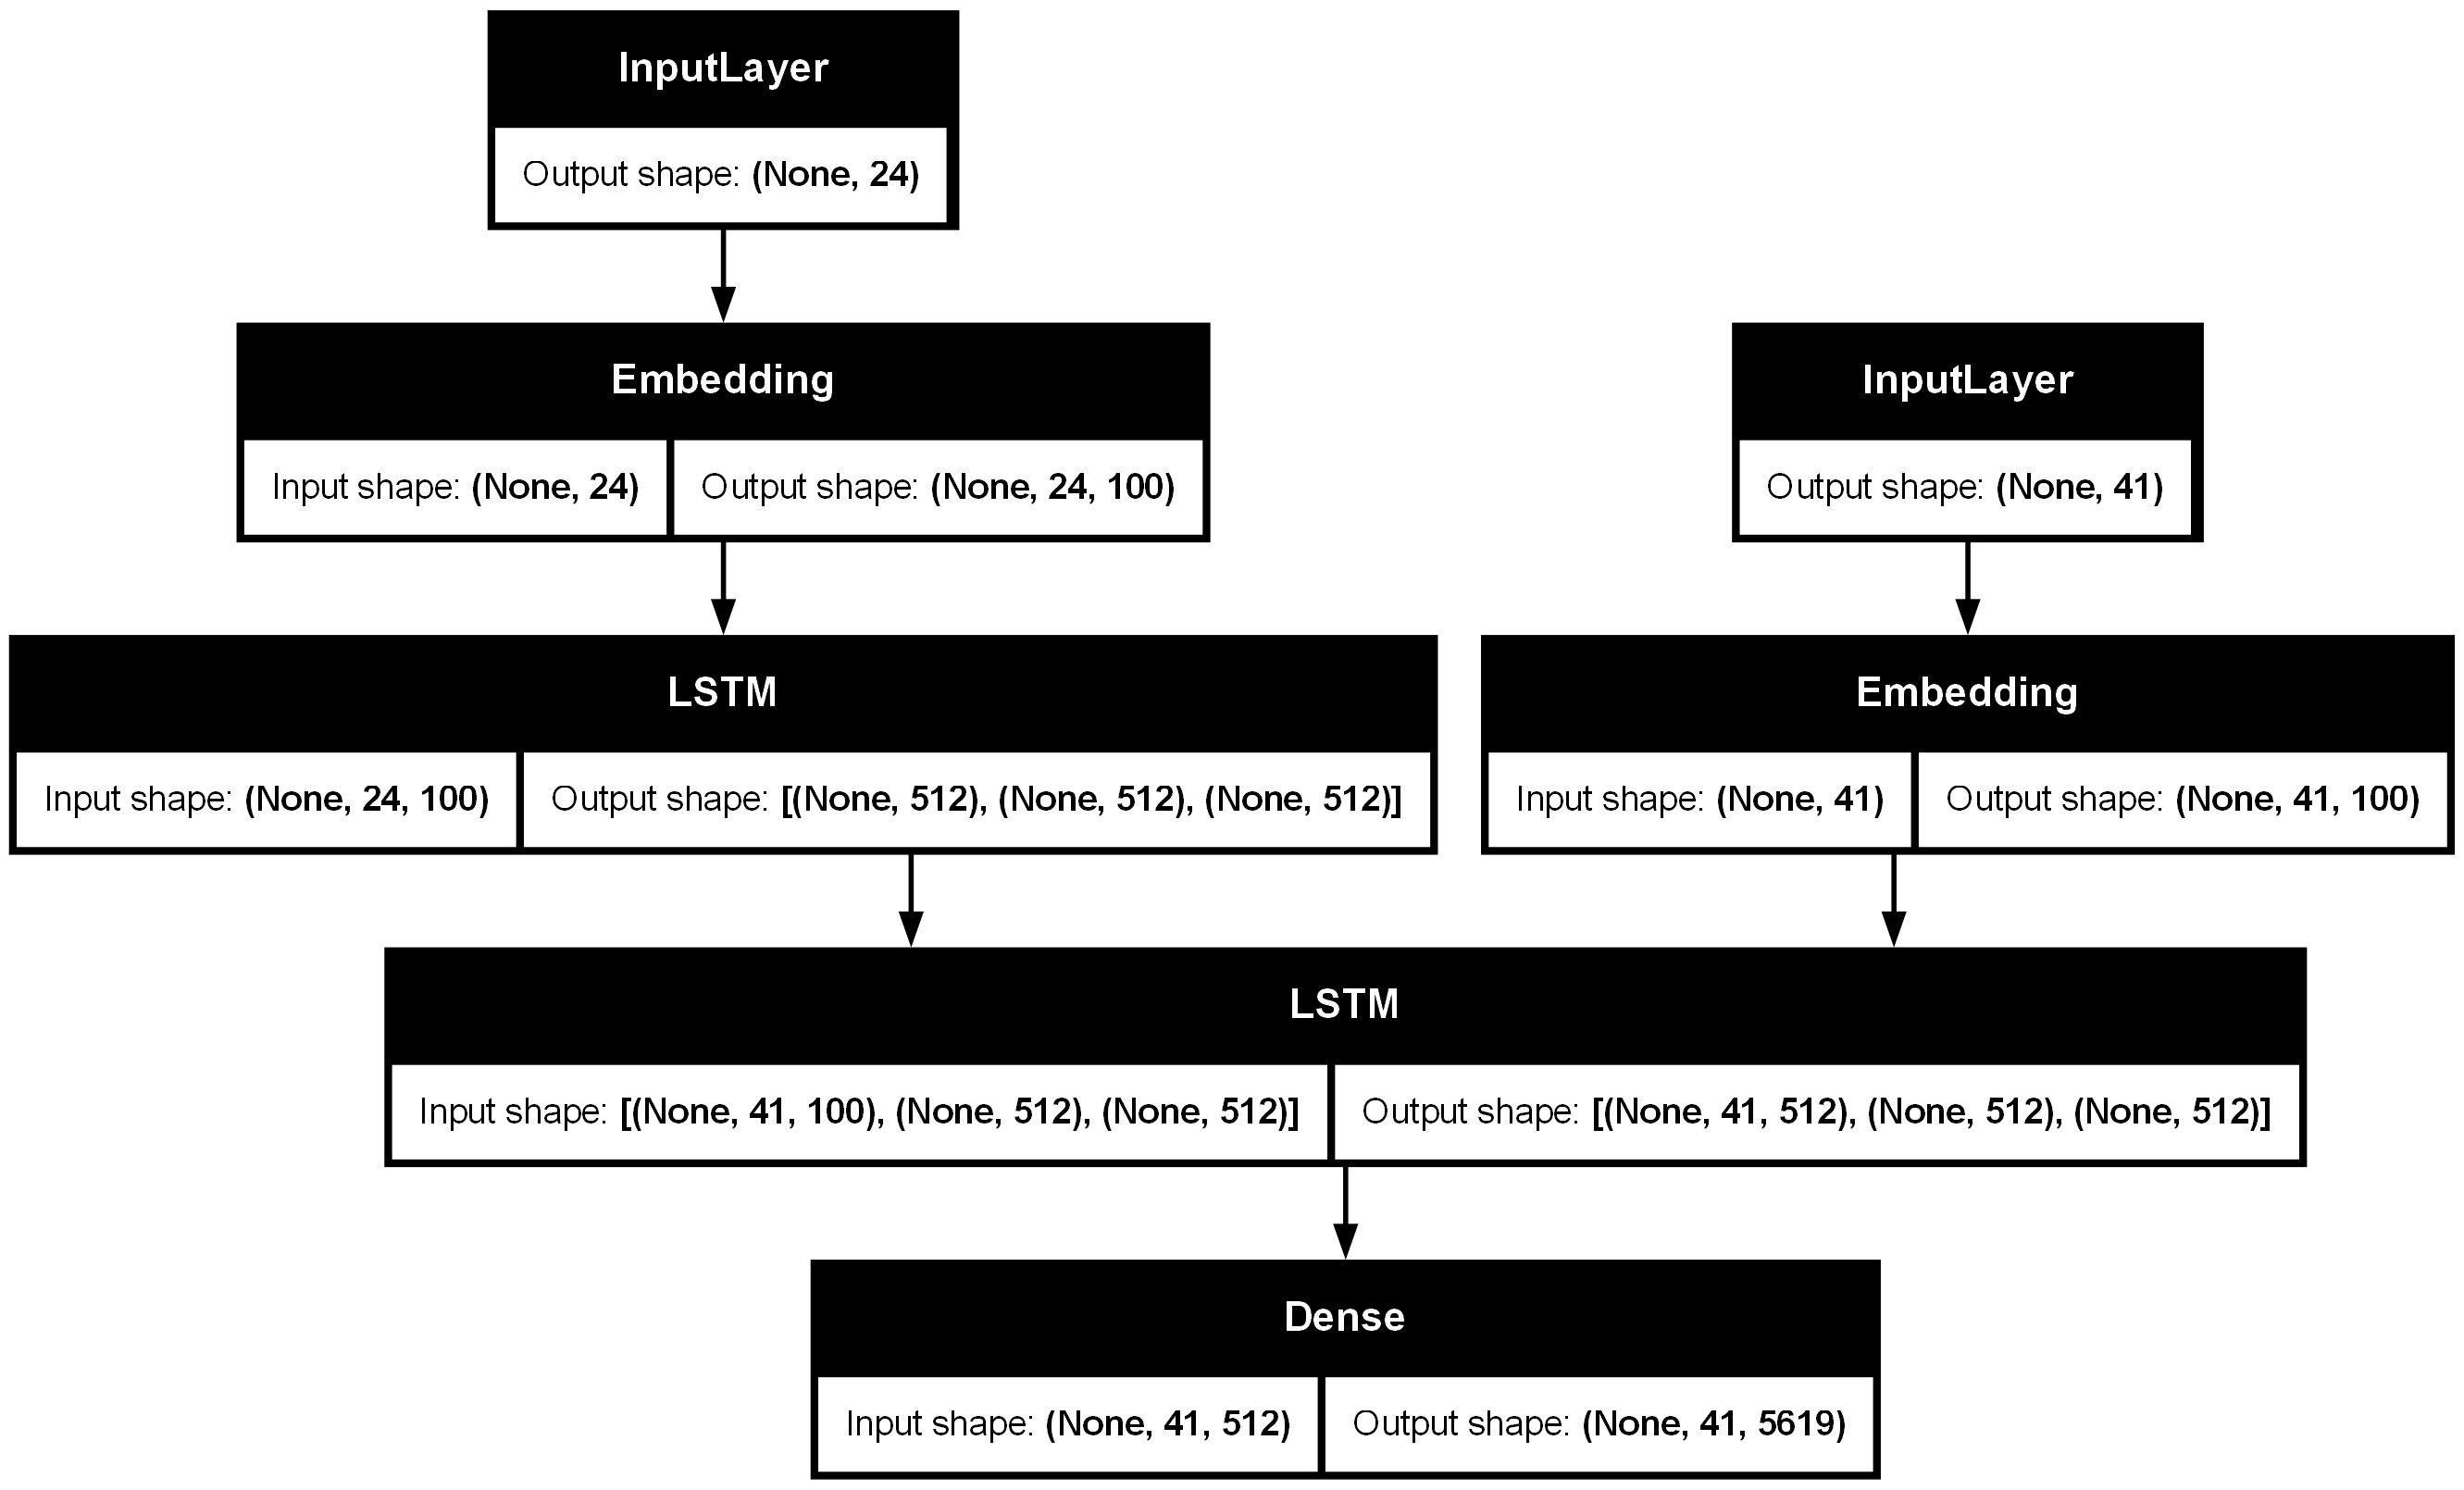

In [21]:
from tensorflow.keras.utils import plot_model

plot_model(decoder_teacher_forcing_model, show_shapes=True, show_layer_names=False)

In [18]:
vocab_size = sp.get_piece_size()
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9000


### 모델 학습

In [25]:
decoder_teacher_forcing_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = decoder_teacher_forcing_model.fit(
    [que_padded, ans_input_padded],
    ans_target_padded,
    epochs=50,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.6971 - loss: 2.8289 - val_accuracy: 0.7145 - val_loss: 1.6355
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 58s 389ms/step - accuracy: 0.7624 - loss: 1.2998 - val_accuracy: 0.7572 - val_loss: 1.5352
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 59s 398ms/step - accuracy: 0.7919 - loss: 1.2053 - val_accuracy: 0.7583 - val_loss: 1.5225
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 62s 421ms/step - accuracy: 0.7950 - loss: 1.1828 - val_accuracy: 0.7594 - val_loss: 1.5142
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 65s 439ms/step - accuracy: 0.8022 - loss: 1.1431 - val_accuracy: 0.7596 - val_loss: 1.5259
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 69s 469ms/step - accuracy: 0.8050 - loss: 1.1316 - val_accuracy: 0.7589 - val_loss: 1.5416
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 76s 512ms/step - accuracy: 0.8107 - loss: 1.0962 - val_accuracy: 0.7579 - val_loss: 1.5678
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 70s 471ms/step - accuracy: 0.8153 - loss: 1

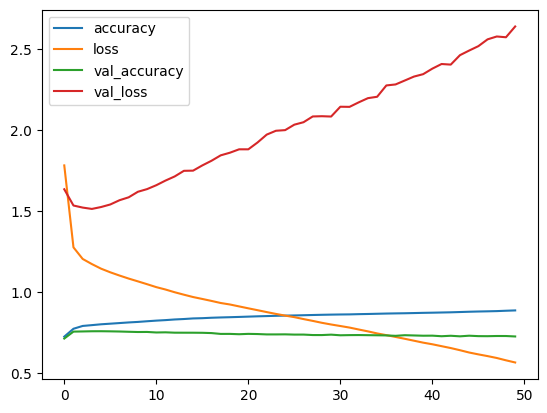

In [26]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

In [27]:
# 모델 저장
decoder_teacher_forcing_model.save('chatbot_decorder_teacher_forcing_model.keras')

##### 학습

##### 디코더 (추론 모델) 생성

In [28]:
# 입력 state( 이전 timetemp의 hidden,state,cell_state)를 받아서 다음 time step의 출력과 state를 반환
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,))
decoder_cell_state = layers.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]

# 토큰 입력 (이전 time step의 출력)
decoder_single_input = layers.Input(shape=(1,))

# 학습된 임베딩
x = que_embedding_layer(decoder_single_input)

# 학습된 LSTM
x,h,c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states = [h,c]

# 출력층
decoder_outputs = decoder_dense(x)

# 추론 모델
decoder_inference_model = models.Model(
    inputs=[decoder_single_input] + decoder_states_inputs,
    outputs=[decoder_outputs] + decoder_states
)
decoder_inference_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 100)    │    900,100 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 1, 512),  │  1,255,424 │ embedding_5[1][0… │
│                     │ (None, 512),      │            │ input_layer_6[0]… │
│                     │ (None, 512)]      │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 9001)   │  4,617,513 │ lstm_5[1][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,773,037 (25.84 MB)

 Trainable params: 6,773,037 (25.84 MB)

 Non-trainable params: 0 (0.00 B)

### 추론 함수
- 추론 함수 생성 및 테스트

In [36]:
def translate(input_seq):
    # 인코더 
    # input_seq 통과 (추론 모델) -> hidden, cell_state 반환
    encoder_states_value = encoder_model.predict(input_seq)
    decoder_states_value = encoder_states_value # 초기값
    
    # 디코더
    # 1. <sos><eos>
    sos_index = sp.piece_to_id('<sos>')
    eos_index = sp.piece_to_id('<eos>')
    
    # sos_index = kor_tokenizer.word_index['<sos>']
    # eos_index = kor_tokenizer.word_index['<eos>']
    
    # 2. traget_seq 준비 (디코더 출력)
    target_seq = np.zeros((1,1))
    target_seq[0,0] = sos_index
    
    # 3. 순차적으로 디코딩(= 번역)
    output_sentence = []

    for _ in range(ans_max_len):
        output_tokens ,h, c = decoder_inference_model.predict([target_seq] + decoder_states_value)

        pred_proba = output_tokens[0,0, :]
        pred_index = np.argmax(pred_proba)

        if pred_index == eos_index:
            break
        
        if pred_index >0:
            word = sp.id_to_piece(int(pred_index))
            # word = kor_tokenizer.index_word[pred_index]
            output_sentence.append(word)
        
        target_seq[0,0] = pred_index
        decoder_states_value = [h,c]

    return (" ".join(output_sentence).replace('▁',' ').strip())


##### 간단한 챗봇 구현

In [37]:
def translate_kor2kor(kor_text):
    input_seq = sp.encode_as_ids(kor_text)
    input_seq = pad_sequences([input_seq], maxlen=que_max_len)
    return translate(input_seq)

kor_texts = [
    "12시 땡!",
    "1지망 학교 떨어졌어",
    "3박4일 놀러가고 싶다",
    "오늘 날씨 어때?",
    "너 이름 뭐야?"
]

for kor_text in kor_texts:
    ans_text = translate_kor2kor(kor_text)
    print(f"Q: {kor_text}")
    print(f"A: {ans_text}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Q: 12시 땡!
A: 도 도 어요 .   <

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Q: 1지망 학교 떨어졌어
A: 좋은 네요 s .   <

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s